In [1]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM, Net, ReCAM    
from misc import imutils
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
train_list = '/Users/Andy/Projects/c2am/voc12/train_aug.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_baseline_512.pth'

cls_dataset = voc12.dataloader.VOC12ClassificationDataset(train_list, voc12_root=voc12_root,
                                                            resize_long=(320, 640), hor_flip=True,
                                                            crop_size=512, crop_method="random")
cls_data_loader = DataLoader(cls_dataset,
                               batch_size=1,
                               shuffle=False,
                               num_workers=0)


cam_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(train_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
cam_data_loader = DataLoader(cam_dataset, batch_size=1, shuffle=False)

cls_model = Net()
cam_model = CAM()
cls_model.eval()
cam_model.eval()
cls_model.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'))
cam_model.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [10]:
label_set = {}
labels = np.zeros((1, 20))
for pack in cls_data_loader:
    label = pack['label'].numpy()
    labels += label
#     if label not in label_set:
#         label_set[label] = 0
#     label_set[label] += 1

In [3]:
# for pack in tqdm(cls_data_loader):
#     names = pack['name']
#     imgs = pack['img']
#     labels = pack['label']
#     if labels[0][14] and labels[0][12] == 0:
#         logits, _ = cls_model(imgs)
#         probs = F.softmax(logits, dim=1)
#         if probs[0][12] > 0.2:
#             print(names)

In [ ]:
for k,v in label_set.items():
    if k[5] or k[14]:
        print(k, v)

In [ ]:
horse_wrong = []

for pack in data_loader:
    

In [33]:
import numpy as np

CAT_LIST = ['aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train',
            'tvmonitor']
idx = np.asarray((0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
print(np.nonzero(idx))
print(CAT_LIST[14])

(array([ 5, 14]),)
person


In [ ]:
from PIL import Image
for pack in data_loader:
    label = pack['label'].numpy().tolist()[0]
    size = pack['size']
    if label[5] or label[14]:
        with torch.no_grad():
            strided_up_size = imutils.get_strided_up_size(size, 16)
            baseline_outputs = [model_baseline(img[0]) for img in pack['img']]
            baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                        o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
            baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                        :, 0, :size[0], :size[1]]
            valid_cat = torch.nonzero(pack['label'][0])[:, 0]
            baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5

        w = size[0].item()
        h = size[1].item()
        fig = plt.figure(figsize=(192.0,108.0))
        columns = 20 + 1
        rows = 1
        n = 20
        for i in range(1, n +1):
            img = baseline_highres_cam[i-1]
            img = img.unsqueeze(0).unsqueeze(0)
            fig.add_subplot(rows, columns, i)
            plt.imshow(img.numpy().squeeze())
            plt.title(CAT_LIST[i-1])
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(Image.open(os.path.join(voc12_root, 'JPEGImages') + '/' + pack['name'][0] + '.jpg'))
        plt.title(pack['name'][0])
        fig.savefig('../cam_vis/{}.png'.format(pack['name'][0]), dpi=fig.dpi)

/Users/Andy/Projects/front_door_cam/.env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


# Results Section CAM Seed Mask

In [38]:
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainercv.evaluations import calc_semantic_segmentation_confusion
from chainercv.evaluations import calc_semantic_segmentation_iou
import numpy as np
import os
import argparse
from misc import pyutils
from tqdm import tqdm

cam_eval_thres = 0.16
chainer_eval_set = 'train'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
cam_out_dir = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/C2AM'

dataset = VOCSemanticSegmentationDataset(split=chainer_eval_set, data_dir=voc12_root)

highest_mious = [float('-inf') for _ in range(20)]
highest_name = ['' for _ in range(20)]
lowest_mious = [float('inf') for _ in range(20)]
lowest_name = ['' for _ in range(20)]

for i, id in enumerate(dataset.ids):
    cam_dict = np.load(os.path.join(cam_out_dir, id + '.npy'), allow_pickle=True).item()
    cams = cam_dict['high_res']
    cams = np.pad(cams, ((1, 0), (0, 0), (0, 0)), mode='constant', constant_values=cam_eval_thres)
    keys = np.pad(cam_dict['keys'] + 1, (1, 0), mode='constant')
    cls_labels = np.argmax(cams, axis=0)
    cls_labels = keys[cls_labels]
    preds = [cls_labels.copy()]
    labels = [dataset.get_example_by_keys(i, (1,))[0]]
    confusion = calc_semantic_segmentation_confusion(preds, labels)
    mious = calc_semantic_segmentation_iou(confusion)
    for cls in cam_dict['keys']:
        miou = mious[cls + 1]
        if miou > highest_mious[cls]:
            highest_mious[cls] = miou
            highest_name[cls] = id 
        if miou < lowest_mious[cls]:
            lowest_mious[cls] = miou
            lowest_name[cls] = id
        
print(highest_mious)
print(highest_name)
print(lowest_mious)
print(lowest_name)

[0.7991936654022346, 0.6286329835290847, 0.7841235954140625, 0.7374581939799331, 0.9431911740490696, 0.8893170937023201, 0.8276068186849679, 0.8948099173553719, 0.7417827298050139, 0.8130109262149793, 0.7620520498827794, 0.8813179284357385, 0.8126252071773438, 0.8125513143949007, 0.8996032352967638, 0.7774765894529325, 0.9228488547662406, 0.8813316203709478, 0.8056176283426812, 0.7836735621215736]
['2010_004721', '2007_009788', '2010_000075', '2008_006065', '2011_000920', '2007_002024', '2008_006215', '2008_005770', '2011_001972', '2010_002139', '2008_002032', '2011_000216', '2011_003184', '2007_009139', '2010_002440', '2009_001137', '2007_004768', '2010_003717', '2011_000197', '2007_001704']
[0.022570415967170306, 0.003313333930330438, 0.032621951219512196, 0.007776282338866457, 0.0, 0.08112407211028633, 0.0, 0.15727649996483084, 0.0, 0.2010643897303936, 0.036847554662281505, 0.046438518600226124, 0.085170261515367, 0.05662943871706758, 0.002403320952589032, 0.005901389682086427, 0.02

(375, 500, 3)
2007_009139


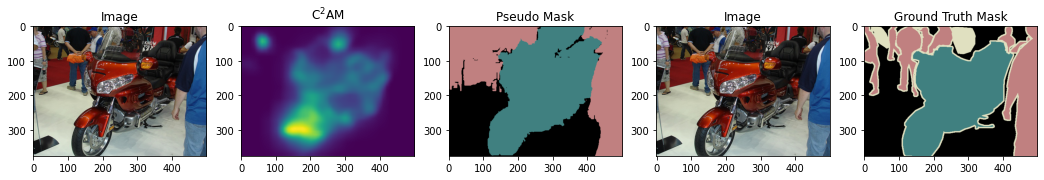

In [36]:
img_name = '2007_009139'
cam_dict = np.load(os.path.join(cam_out_dir, img_name + '.npy'), allow_pickle=True).item()
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
pseudo = Image.open(os.path.join(voc12_root, 'SegmentationClassAug', img_name + '.png'))
pseudo_color = imutils.colorize_label(np.asarray(pseudo), by_hue=False, normalize=False)
print(pseudo_color.shape)
pseudo_color = Image.fromarray(pseudo_color.astype(np.uint8))
gt = Image.open(os.path.join(voc12_root, 'SegmentationClass', img_name + '.png'))
print(img_name)

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(351)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(352)
plt.title('C$^2$AM')
ax2.imshow(cam_dict['high_res'][0].squeeze())
ax2 = fig.add_subplot(353)
plt.title('Pseudo Mask')
ax2.imshow(pseudo_color)
ax1 = fig.add_subplot(354)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(355)
plt.title('Ground Truth Mask')
ax2.imshow(gt)

(333, 500, 3)
2010_005318


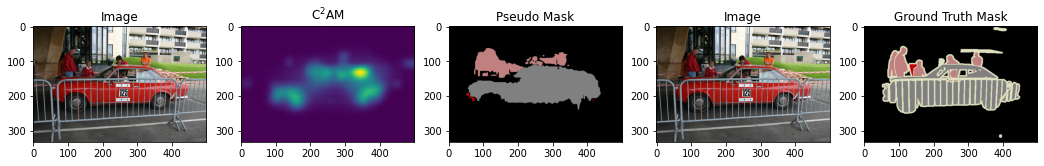

In [41]:
img_name = '2010_005318'
cam_dict = np.load(os.path.join(cam_out_dir, img_name + '.npy'), allow_pickle=True).item()
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
pseudo = Image.open(os.path.join(voc12_root, 'SegmentationClassAug', img_name + '.png'))
pseudo_color = imutils.colorize_label(np.asarray(pseudo), by_hue=False, normalize=False)
print(pseudo_color.shape)
pseudo_color = Image.fromarray(pseudo_color.astype(np.uint8))
gt = Image.open(os.path.join(voc12_root, 'SegmentationClass', img_name + '.png'))
print(img_name)

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(351)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(352)
plt.title('C$^2$AM')
ax2.imshow(cam_dict['high_res'][0].squeeze())
ax2 = fig.add_subplot(353)
plt.title('Pseudo Mask')
ax2.imshow(pseudo_color)
ax1 = fig.add_subplot(354)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(355)
plt.title('Ground Truth Mask')
ax2.imshow(gt)